# setup

In [1]:
import os
os.chdir('/Users/martinmarek/Google Drive/UCL/STAT0035/')

# imports

In [2]:
# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pickle
from functools import partial

# relative imports
from core import models, distributions, datasets, utils, metrics
from core.sgd import train_sgd, train_ensamble
from core.rwmh import rwmh_sampler
from core.hmc import hmc_sampler
from core.nuts import nuts_sampler

/Users/martinmarek/miniforge3/envs/py39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

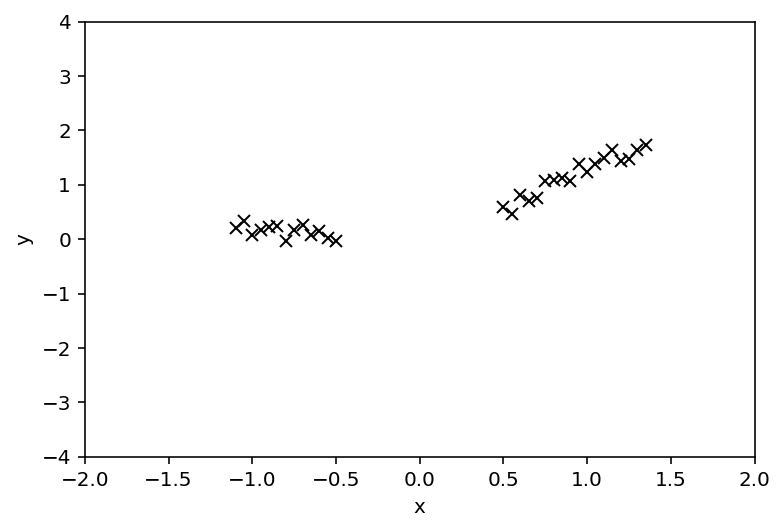

In [4]:
(x_true, y_true), (x_train, y_train), (x_test, y_test) = datasets.load_1d_regression_dataset()
fig, ax = plt.subplots()
# ax.plot(x_true[:, 0], y_true, label='true')
# ax.plot(x_test[:, 0], y_test, 'x', c='red', alpha=0.2, label='measured')
ax.plot(x_train[:, 0], y_train, 'x', c='black', label='measured')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
# ax.legend()
plt.savefig('plots/1d_dataset.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# model

In [5]:
# define model
key = jax.random.PRNGKey(0)
layer_dims = 1*[50]
prior_sd = 1
init_sd = 0.1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
n_params = len(params_init)
params_init = init_sd*jax.random.normal(key, [n_params])
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior_fn(x_train, y_train, log_likelihood_fn, log_prior_fn)

In [6]:
# test model
print('num. params: ', n_params)
print('PDF test: ', log_prior_fn(params_init), log_likelihood_fn(params_init, x_train, y_train))

num. params:  202
PDF test:  -186.65285 -48.749596


# training

In [7]:
# number of samples to keep from each chain
n_samples = 2_000

## SGD

In [8]:
%%time
n_epochs = 10_000
lr_start = 1e-3
lr_stop = 1e-5
params_sgd, loss_sgd, _ = train_sgd(log_posterior_fn, params_init, n_epochs, lr_start, lr_stop)
chain_sgd = params_sgd[None]

CPU times: user 325 ms, sys: 6.05 ms, total: 331 ms
Wall time: 329 ms


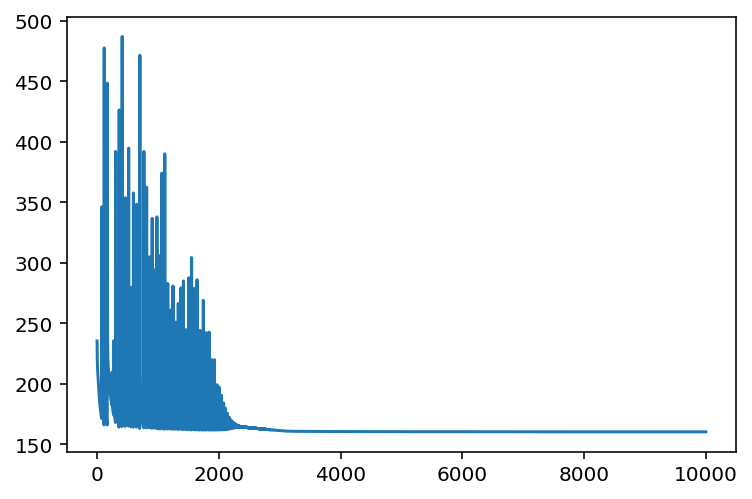

160.24736


In [9]:
fig, ax = plt.subplots()
ax.plot(loss_sgd)
plt.show()
print(loss_sgd[-1])

## HMC

In [10]:
%%time
hmc_step_size = 1e-3
n_leapfrog_steps = 5_000
key = jax.random.PRNGKey(0)
chain_hmc, avg_accept_prob = hmc_sampler(log_posterior_fn, params_sgd, key, n_samples, n_leapfrog_steps, hmc_step_size)
print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

Avg. accept. prob.: 88.35%
CPU times: user 1min 19s, sys: 198 ms, total: 1min 19s
Wall time: 1min 19s


## create dict. of chains

In [11]:
chains_dict = {
    'sgd': chain_sgd,
    'hmc': chain_hmc,
}

# predictions

## overlaid

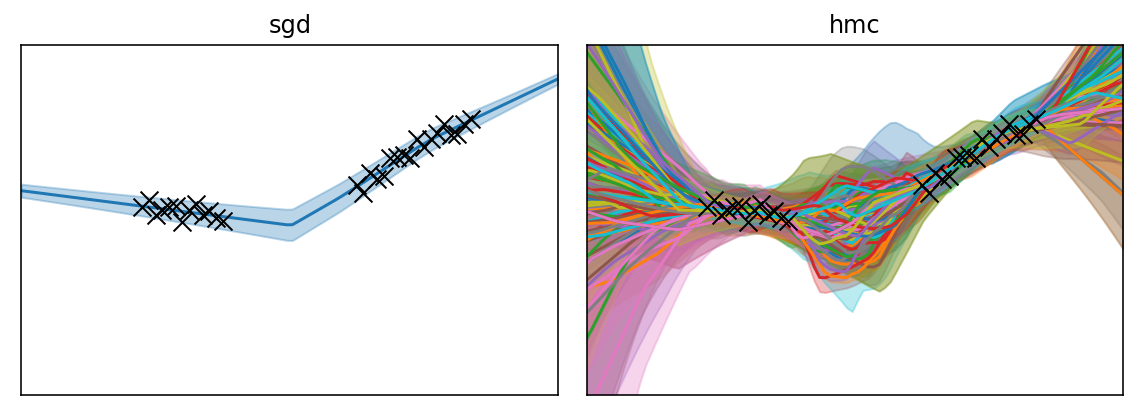

In [12]:
fig, axs = plt.subplots(1, 2, figsize=[8, 3])
axs = axs.flatten()

x_full = jnp.linspace(-2, 2, 100)[:, None]
for i, (name, chain) in enumerate(chains_dict.items()):
    for j, params in enumerate(chain[:100]):
        y_hat = predict_fn(x_full, params)
        axs[i].fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3, color=f'C{j}')
        axs[i].plot(x_full[:, 0], y_hat[:, 0], color=f'C{j}')
        
    axs[i].scatter(x_train[:, 0], y_train, marker='x', c='black', s=80, linewidth=1, zorder=10)
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-3, 3])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(name)

plt.tight_layout()
plt.savefig('plots/1d_predictions_overlaid.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## PDF

In [13]:
def get_pdf(chain):
    # create grid to evaluate posterior predictive density
    nx, ny = 800, 400
    x_full = jnp.linspace(-2, 2, nx)
    y_full = jnp.linspace(-4, 4, ny)

    def get_posterior_density(params):
        y_hat = predict_fn(x_full[:, None], params)
        mean, std = y_hat[:, 0], y_hat[:, 1]
        log_prob = distributions.gaussian_log_pdf(y_full[None, :], mean[:, None], std[:, None])
        log_prob = jnp.nan_to_num(log_prob)
        return log_prob

    density_fn_vmap = jax.vmap(get_posterior_density)
    z_full = density_fn_vmap(chain)

    # average over posterior samples
    # - p(y) = sum (p(y|theta_i) * p(theta_i)) = (sum p(y|theta_i)) / n
    # - p(y) = (sum exp logp(y|theta_i)) / n
    # - logp(y) = log((sum exp logp(y|theta_i)) / n)
    # - logp(y) = (log-sum-exp logp(y|theta_i)) - log(n)
    log_z_full = jax.scipy.special.logsumexp(z_full, 0) - jnp.log(len(chain))
    z_full = jnp.exp(log_z_full)

    return x_full, y_full, z_full

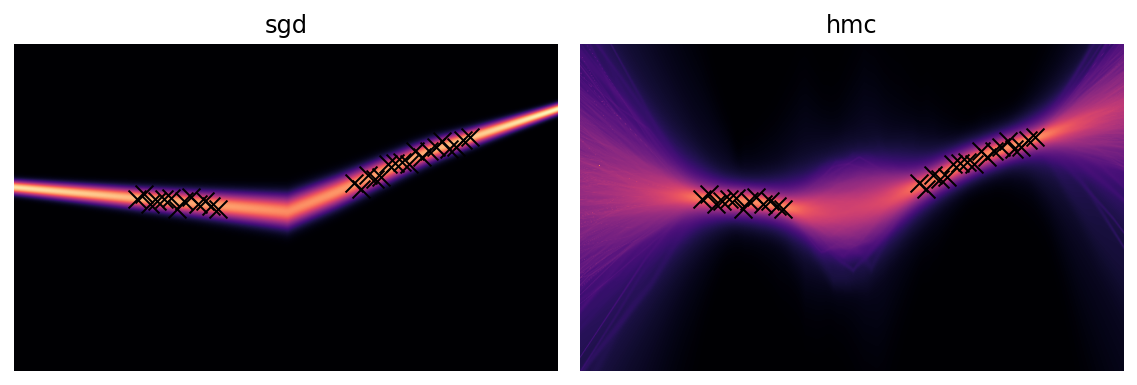

In [14]:
fig, axs = plt.subplots(1, 2, figsize=[8, 3])
axs = axs.flatten()

for i, (name, chain) in enumerate(chains_dict.items()):
    x_full, y_full, z_full = get_pdf(chain)
    extent = [x_full[0], x_full[-1], y_full[0], y_full[-1]]
    axs[i].imshow(z_full.T**(1/4), origin='lower', cmap='magma', extent=extent, aspect=0.3)
    axs[i].axis('off')
    axs[i].scatter(x_train[:, 0], y_train, marker='x', color='black', s=80, linewidth=1)
    axs[i].set_title(name)
    

plt.tight_layout()
plt.savefig('plots/1d_predictions_pdf.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## confidence interval

In [15]:
def get_quantiles(key, x, chain, n_samples=10_000):
    n_samples_per_step = n_samples // len(chain)
    
    # generate samples
    def sample_from_node(key, params):
        y_hat = predict_fn(x[:, None], params)
        mean = y_hat[:, 0]
        std = y_hat[:, 1]
        samples = mean[:, None] + std[:, None] * jax.random.normal(key, [len(x), n_samples_per_step])
        return samples
    keys = jax.random.split(key, len(chain))
    samples = jax.vmap(sample_from_node)(keys, chain) # [len(chain), len(x), n_samples_per_step]
    samples = samples.transpose([1, 0, 2]).reshape([len(x), n_samples])

    # get posterior predictive quntiles (alpha/2, 0/5, alpha)
    quantiles = jnp.quantile(samples, jnp.array([alpha/2, 0.5, 1-alpha/2]), axis=1)
    return quantiles

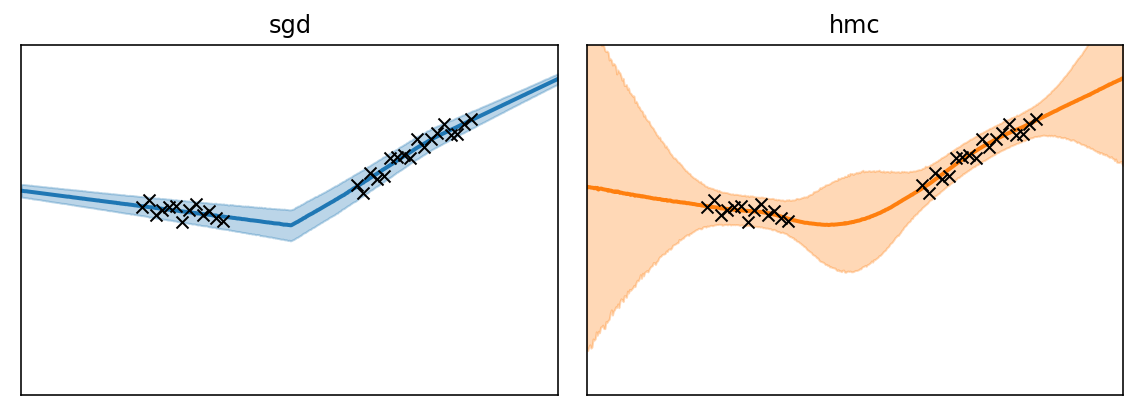

In [16]:
fig, axs = plt.subplots(1, 2, figsize=[8, 3])
axs = axs.flatten()
key = jax.random.PRNGKey(0)
alpha = 0.05
nx = 500
x_full = jnp.linspace(-2, 2, nx)


for i, (name, chain) in enumerate(chains_dict.items()):
    quantiles = get_quantiles(key, x_full, chain)
    axs[i].fill_between(x_full, quantiles[0, :], quantiles[2, :], alpha=0.3, color=f'C{i}')
    axs[i].plot(x_full, quantiles[1, :], lw=2, color=f'C{i}')
    axs[i].scatter(x_train[:, 0], y_train, marker='x', color='black', linewidth=1, zorder=5)
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-3, 3])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(name)

plt.tight_layout()
plt.savefig('plots/1d_predictions_ci.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## varying prior scale

In [24]:
prior_sd_list = [0.1, 0.2, 0.5, 1, 3, 10]
step_size = 1e-4
n_samples_sd = 500
chains_by_prior = {}
for sd in prior_sd_list:
    log_prior_fn = distributions.make_gaussian_log_prior(sd)
    log_posterior_fn = distributions.make_log_posterior_fn(x_train, y_train, log_likelihood_fn, log_prior_fn)
    chain, avg_accept_prob = hmc_sampler(log_posterior_fn, params_sgd, key, n_samples_sd, n_leapfrog_steps, step_size)
    print(f'Prior: {sd}, accept. prob.: {avg_accept_prob.mean():.2%}')
    chains_by_prior[sd] = chain

Prior: 0.1, accept. prob.: 99.98%
Prior: 0.2, accept. prob.: 99.94%
Prior: 0.5, accept. prob.: 99.76%
Prior: 1, accept. prob.: 99.63%
Prior: 3, accept. prob.: 99.08%
Prior: 10, accept. prob.: 88.85%


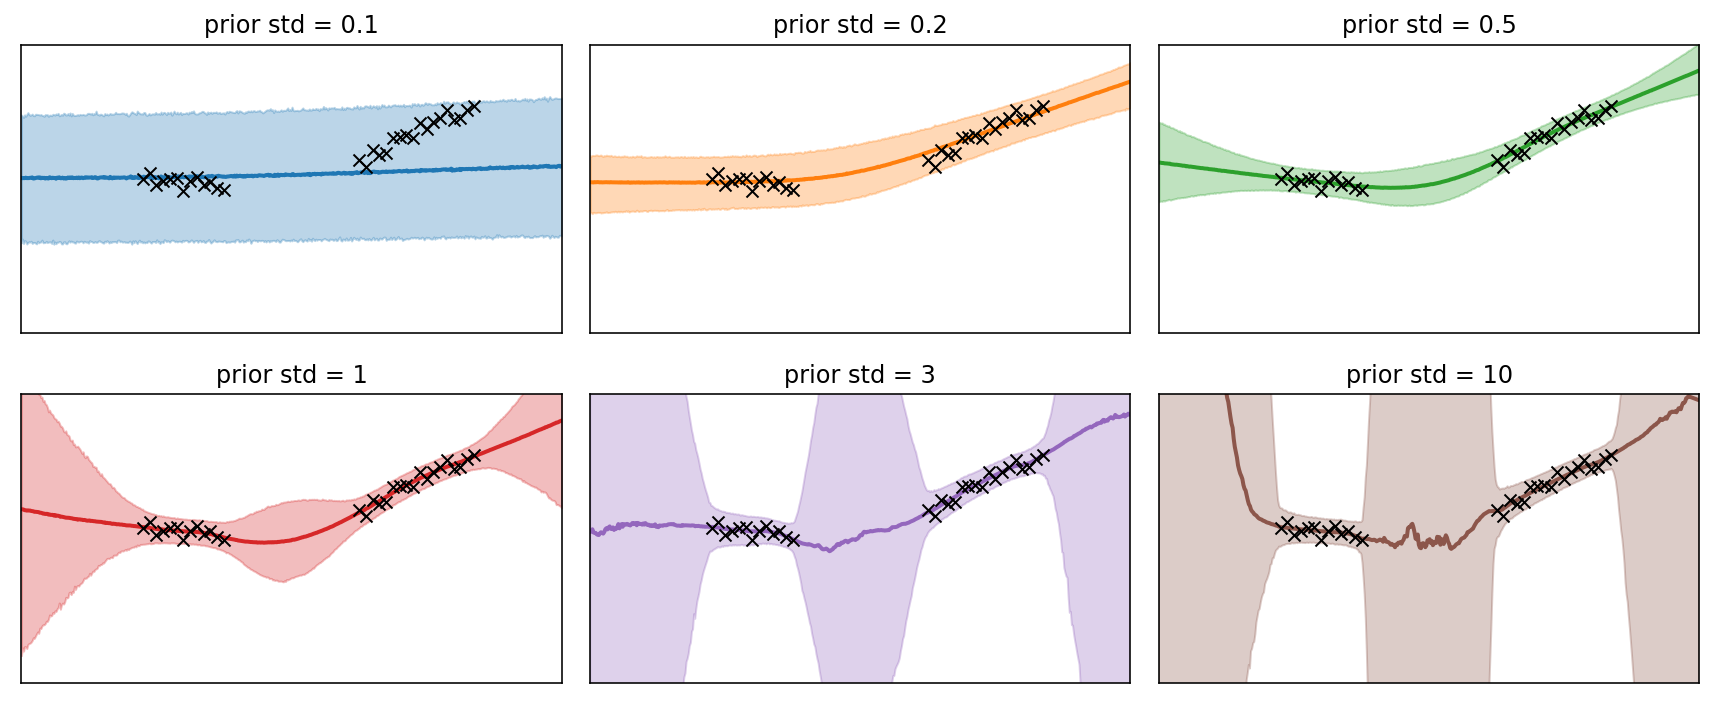

In [25]:
fig, axs = plt.subplots(2, 3, figsize=[12, 5])
axs = axs.flatten()
key = jax.random.PRNGKey(0)
alpha = 0.05
nx = 500
x_full = jnp.linspace(-2, 2, nx)


for i, (sd, chain) in enumerate(chains_by_prior.items()):
    quantiles = get_quantiles(key, x_full, chain)
    axs[i].fill_between(x_full, quantiles[0, :], quantiles[2, :], alpha=0.3, color=f'C{i}')
    axs[i].plot(x_full, quantiles[1, :], lw=2, color=f'C{i}')
    axs[i].scatter(x_train[:, 0], y_train, marker='x', color='black', linewidth=1, zorder=5)
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-3, 3])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f'prior std = {sd}')

plt.tight_layout()
plt.savefig('plots/1d_predictions_by_stdev.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## loss geometry

### independent solutions

In [22]:
%%time
ens_size = 6
key = jax.random.PRNGKey(1)
chain_ens = 0.22*jax.random.normal(key, [ens_size, n_params])
chain_ens, loss_history, ens_params_history = train_ensamble(log_posterior_fn, chain_ens, n_epochs, lr_start, lr_stop)

CPU times: user 1.03 s, sys: 47.6 ms, total: 1.08 s
Wall time: 991 ms


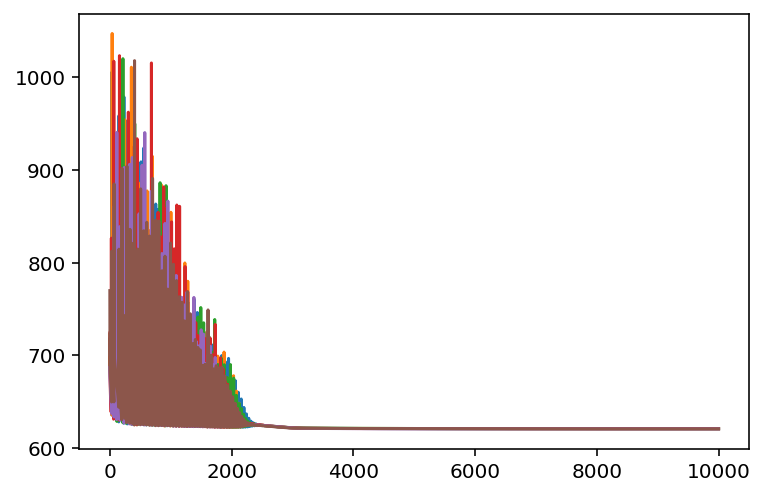

In [23]:
for i in range(ens_size):
    plt.plot(loss_history[i])

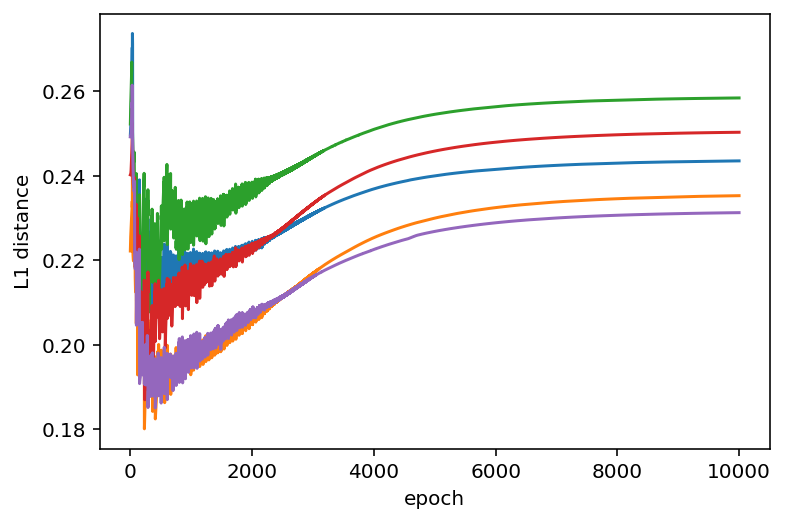

In [24]:
# show that independent sgd solutions differ in weights
fig, ax = plt.subplots()
x = ens_params_history[1:] - ens_params_history[0]
x = jnp.abs(x).mean(2)
for sol_idx in range(5):
    ax.plot(x[sol_idx])

ax.set_xlabel('epoch')
ax.set_ylabel('L1 distance')
plt.savefig('plots/1d_ens_param_distance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [25]:
print(jnp.abs(ens_params_history[:, [0, -1], :]).mean([2]))

[[0.16756871 0.18097332]
 [0.18936482 0.2041284 ]
 [0.15935318 0.19028659]
 [0.17983085 0.21196344]
 [0.16465056 0.19203371]
 [0.18150209 0.19495597]]


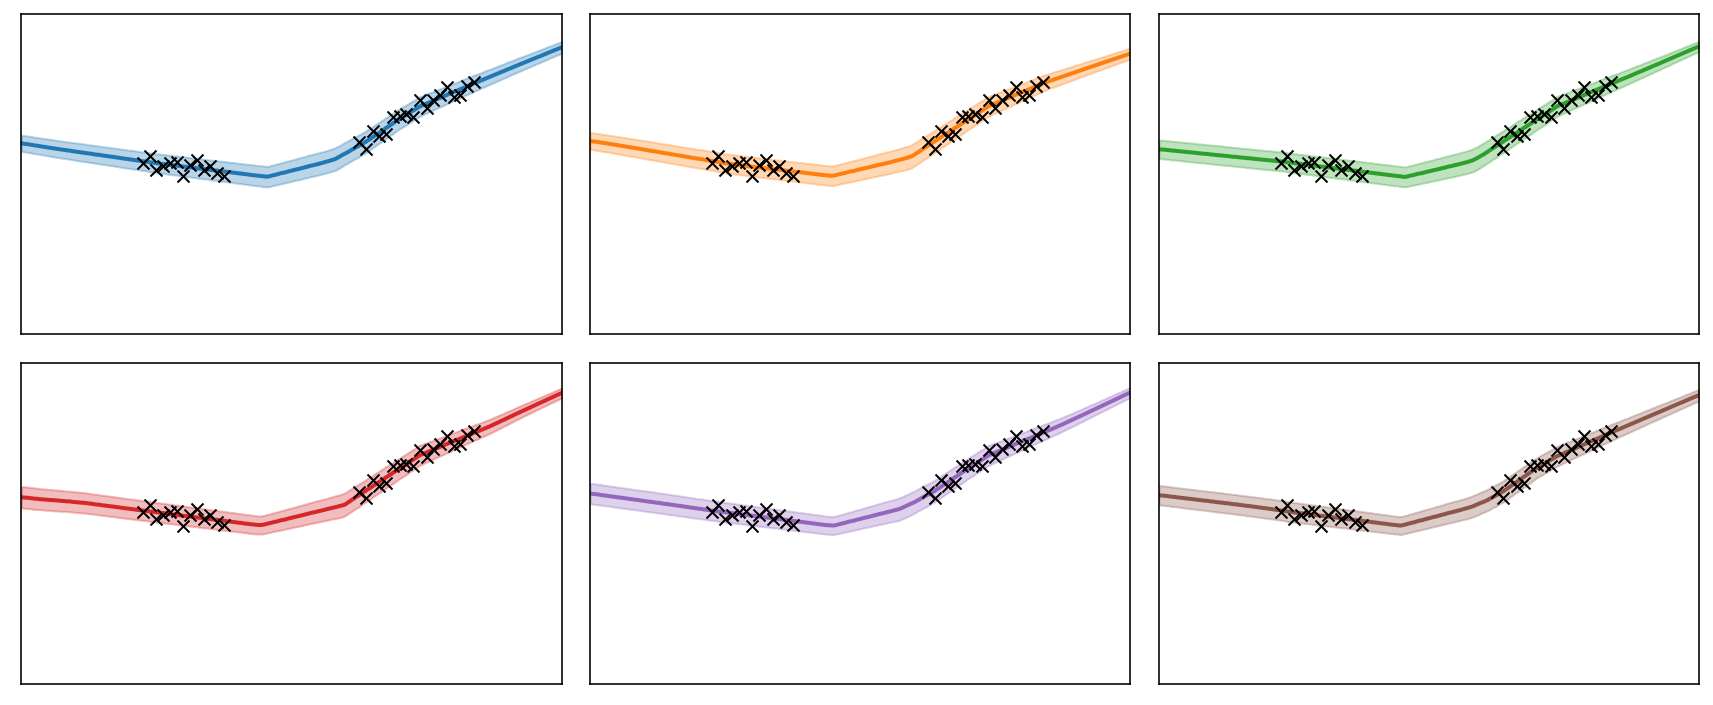

In [26]:
fig, axs = plt.subplots(2, 3, figsize=[12, 5])
axs = axs.flatten()
key = jax.random.PRNGKey(0)
alpha = 0.05
nx = 500
x_full = jnp.linspace(-2, 2, nx)


for i in range(6):
    quantiles = get_quantiles(key, x_full, chain_ens[i, None])
    axs[i].fill_between(x_full, quantiles[0, :], quantiles[2, :], alpha=0.3, color=f'C{i}')
    axs[i].plot(x_full, quantiles[1, :], lw=2, color=f'C{i}')
    axs[i].scatter(x_train[:, 0], y_train, marker='x', color='black', linewidth=1, zorder=5)
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-3, 3])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.savefig('plots/1d_ens_predictions.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [27]:
# test: loss when averaging solutions
sol_idxs = [0, 1, 2]
s0, s1, s2 = chain_ens[sol_idxs, :]
sa0 = (s0 + s1) / 2
sa1 = (s0 + s2) / 2
sa2 = (s1 + s2) / 2
sa3 = (s0 + s1 + s2) / 3
r = 0.5*jax.random.normal(key, s0.shape)
for s in [s0, s1, s2, sa0, sa1, sa2, sa3, r]:
    print(log_posterior_fn(s))

-620.7235
-620.8091
-620.848
-889.0757
-892.07526
-890.53204
-974.7444
-725321.9


In [36]:
def plot_loss_landscape(s0, s1, s2, scale=40, floor=-100_000, m=0.7, n_points=100):
    # grid of (x, y) coordinates
    x = jnp.linspace(-1-m, 1+m, n_points)
    y = jnp.linspace(-m, 1+m, n_points)

    # grid of coordinates in params space
    sm = (s0 + s1)/2
    dx = s1 - sm
    dy = s2 - sm
    params_grid = sm[None, None, :] + x[:, None, None]*dx[None, None, :] + y[None, :, None]*dy[None, None, :]
    params_flat = params_grid.reshape([-1, n_params])

    # evaluate loss at at each point in the grid
    loss_fn = log_posterior_fn
    loss_flat = jax.lax.map(log_posterior_fn, params_flat)
    loss_grid = loss_flat.reshape([n_points, n_points])
    
    # clip the loss
    loss_grid = loss_grid.at[jnp.isnan(loss_grid) | (loss_grid < floor)].set(floor)
    
    # map z to [0, 1]
    z = loss_grid
    z = (z - z.max()) # [min, 0]
    z = (-scale/jnp.min(z)) * z # [scale, 0]
    z = jnp.exp(scale*z) # [0, 1]

    fig, ax = plt.subplots(figsize=[7, 5])
    extent = [-1-m, 1+m, -m, 1+m]
    ax.contourf(z.T, cmap='magma', levels=10, origin='lower', extent=extent)

    ax.axis('off')
    plt.tight_layout()
    return fig, ax

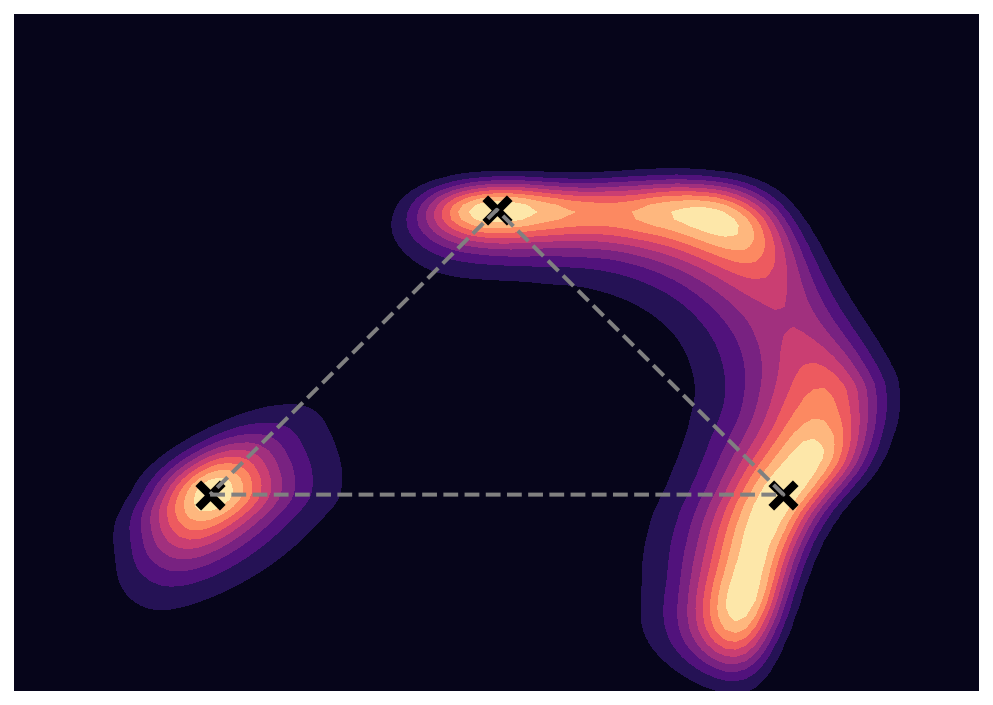

In [37]:
sol_idxs = [1, 0, 4]
s0, s1, s2 = chain_ens[sol_idxs, :]
fig, ax = plot_loss_landscape(s0, s1, s2)
ax.plot([-1, 1, 0, -1], [0, 0, 1, 0], ls='--', c='grey', linewidth=2)
ax.scatter([-1, 1, 0], [0, 0, 1], marker='x', c='black', s=150, linewidth=4)
plt.savefig('plots/loss_landscape.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

### mode connectivity

In [30]:
%%time
# find a quadratic mode cennection
w0 = s0
w1 = s2

@partial(jax.vmap, in_axes=[None, None, None, 0])
def quadratic_bezier_curve(x0, x1, theta, t):
    return (1-t)**2 * x0 + 2*t*(1-t)*theta + t**2 * x1

# define loss along the mode-connecting path
def posterior_along_path(w2, n=20):
    t = jnp.linspace(0, 1, n)
    w = quadratic_bezier_curve(w0, w1, w2, t)
    log_prob = jax.vmap(log_posterior_fn)(w).sum()
    return log_prob

# train
theta = jnp.zeros_like(w0)
theta, w2_loss, _ = train_sgd(posterior_along_path, theta, n_epochs, lr_start, lr_stop)
w2 = quadratic_bezier_curve(w0, w1, theta, jnp.array([0.5]))[0]

CPU times: user 2.53 s, sys: 63.4 ms, total: 2.59 s
Wall time: 2.34 s


In [31]:
for w in [w0, w1, w2]:
    print(jnp.abs(w).mean(), log_prior_fn(w), log_likelihood_fn(w, x_train, y_train))

0.2041284 -650.8407 30.031614
0.19203371 -650.8302 30.144346
0.17476484 -650.8377 29.625116


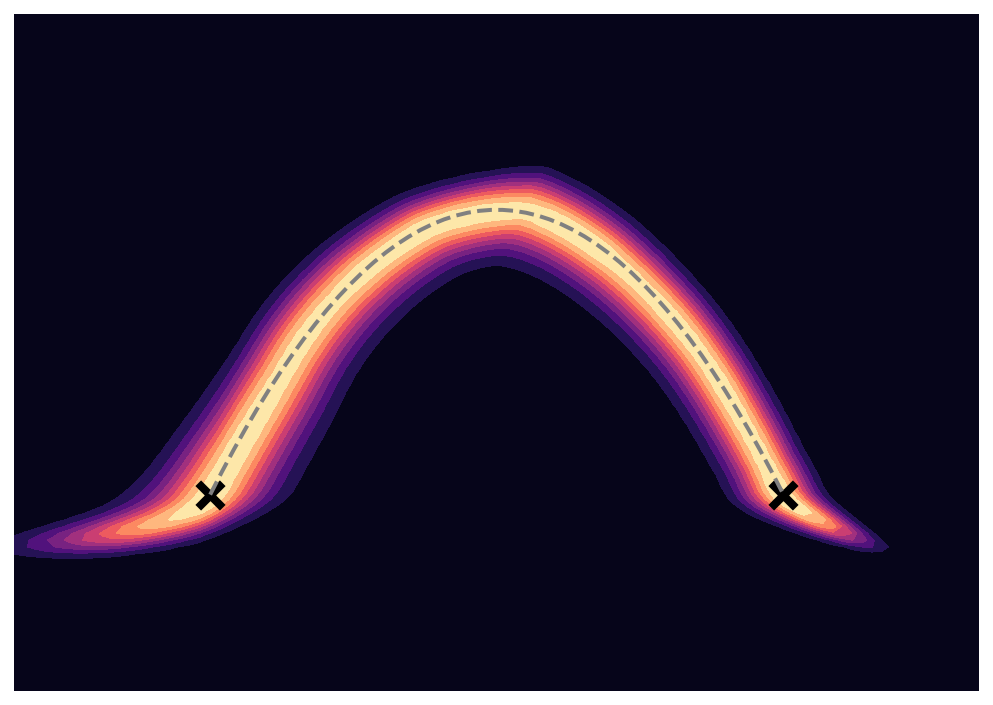

In [38]:
fig, ax = plot_loss_landscape(w0, w1, w2, scale=80)
x0 = jnp.array([-1, 0])
x1 = jnp.array([1, 0])
x2 = jnp.array([0, 1])
theta_plot = 2*x2 - 0.5*x0 - 0.5*x1
t = jnp.linspace(0, 1, 50)
x = quadratic_bezier_curve(x0, x1, theta_plot, t)
ax.plot(x[:, 0], x[:, 1], ls='--', c='grey', linewidth=2)
ax.scatter([-1, 1], [0, 0], marker='x', c='black', s=150, linewidth=4)
plt.savefig('plots/mode_connectivity.pdf', bbox_inches='tight', pad_inches=0)
plt.show()